In [1]:
import sys
from os import getcwd, makedirs
from os.path import join, exists, abspath
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from scipy.stats import ttest_1samp, pearsonr
from scipy.spatial.distance import squareform
import h5py
import seaborn as sns

from tqdm import tqdm

In [2]:
import warnings

In [3]:
import nibabel as nb
from nilearn import plotting
from nipype.interfaces import fsl

In [4]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/Users/sungbeenpark/github'

In [5]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [6]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [7]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [8]:
dname = abspath(join(dir_git,'PcmPy'))
sys.path.append(dname)
import PcmPy as pcm

In [9]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import image as simage

---

In [12]:
glm = 1

## Load $\beta$ (ROI)

In [13]:
roi = 'M1'
param = [5,15]

In [14]:
subj = 'S01'

In [15]:
reginfo = su.get_reginfo(subj=subj, glm=glm)
reginfo

,sn,run,cond,regIdx,seq,cue,reg
0,1,1,1,1,1,L,"(1,L)"
1,1,1,2,2,1,S,"(1,S)"
2,1,1,3,3,2,L,"(2,L)"
3,1,1,4,4,2,S,"(2,S)"
4,1,1,5,5,3,L,"(3,L)"
...,...,...,...,...,...,...,...
59,1,8,4,60,2,S,"(2,S)"
60,1,8,5,61,3,L,"(3,L)"
61,1,8,6,62,3,S,"(3,S)"
62,1,8,7,63,4,L,"(4,L)"


In [16]:
beta_whiten = simage.get_prewhitened_beta(subj=subj,glm=glm,region=roi,param=param)
beta_whiten.shape

(64, 565)

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
beta_pca = pca.fit_transform(beta_whiten)
print(beta_pca.shape)

(64, 2)


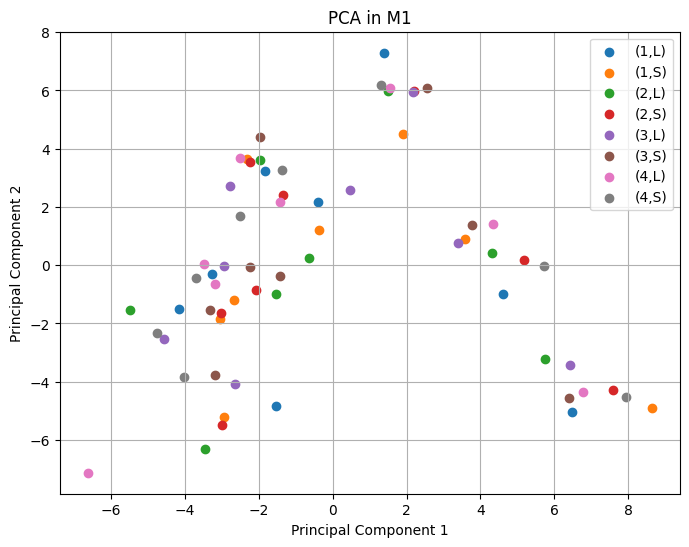

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
for ii, reg in enumerate(reginfo.reg.unique()):
    ax.scatter(
        x = beta_pca[reginfo.reg == reg, 0],
        y = beta_pca[reginfo.reg == reg, 1],
        label=reg
    )

ax.grid(axis='both')
ax.set_title('PCA in %s'%roi)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.legend()
plt.show()

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)

beta_lda = lda.fit_transform(X=beta_whiten, y=reginfo.reg)
print(beta_lda.shape)

(64, 2)


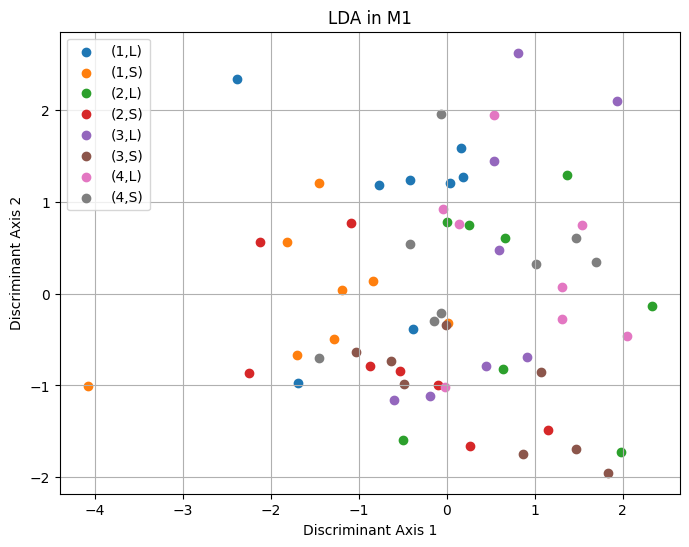

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
for ii, reg in enumerate(reginfo.reg.unique()):
    ax.scatter(
        x = beta_lda[reginfo.reg == reg, 0],
        y = beta_lda[reginfo.reg == reg, 1],
        label=reg
    )
    
ax.grid(axis='both')
ax.set_title('LDA in %s'%roi)
ax.set_xlabel('Discriminant Axis 1')
ax.set_ylabel('Discriminant Axis 2')
ax.legend()
plt.show()

---

## Freesurfer

In [24]:
dname = join(dir_git,'surfAnalysisPy')
# underlay = su.get_underlay(dname, hemi='L')
border = simage.get_border(dname, hemi='L')

In [25]:
list_roi = simage.get_list_roi()
list_roi

array(['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp'], dtype='<U4')

In [26]:
dir_atlas = su.get_dir_atlas()

9 [0 1 2 3 4 5 6 7 8]


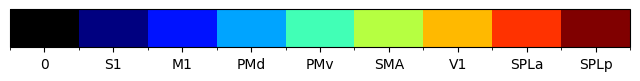

In [27]:
# data = nb.load(join(dir_atlas,'ROI.L.SSS.label.gii'))
surf_roi = nb.load(join(dir_atlas,'ROI.32k.L.label.gii'))
tmp = np.unique(surf_roi.darrays[0].data)
print(len(tmp), tmp)

cmap = splt.cmap_for_cbar(list_roi, cmap='jet')

<Axes: >

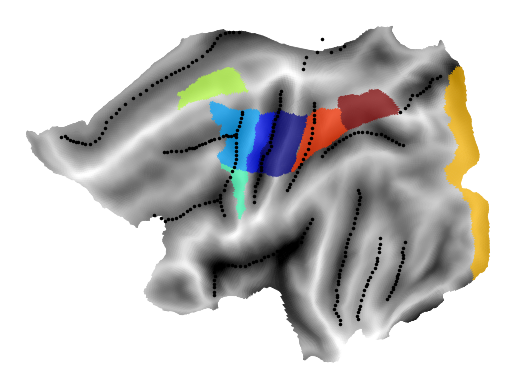

In [28]:
fig, ax = plt.subplots()

plt.sca(ax)
surf.plot.plotmap(
    data=surf_roi,
    surf='fs32k_L',
    alpha=0.7, cmap=cmap, colorbar=False,
    borders=border, bordercolor='black', bordersize=3,
    overlay_type='func', render='matplotlib'
)
# fig.savefig(
#     join(dir_result,'fig.ROI.png'),
#     dpi=300, facecolor=[1,1,1,1],
#     bbox_inches='tight'
# )

---

## Load $\beta$ (whole brain)

### Individual Data

In [29]:
subj = 'S01'

In [30]:
beta = simage.get_prewhitened_beta(subj=subj, glm=glm)

In [31]:
list_label = sorted(reginfo.reg.unique())
list_label

['(1,L)', '(1,S)', '(2,L)', '(2,S)', '(3,L)', '(3,S)', '(4,L)', '(4,S)']

### Group Data

In [32]:
nsess = 2
nsubj = 12
nbetas = 64

Y = np.ones((nsess*nsubj, nbetas, 32492)) * np.nan
print(Y.shape)

for ii, ss in enumerate(['S','R']):
    for jj, nn in enumerate(list_nn):
        idx = ii*len(list_nn) + jj
        subj = ss+nn
        Y[idx] = simage.get_prewhitened_beta(subj=subj, glm=glm)

(24, 64, 32492)


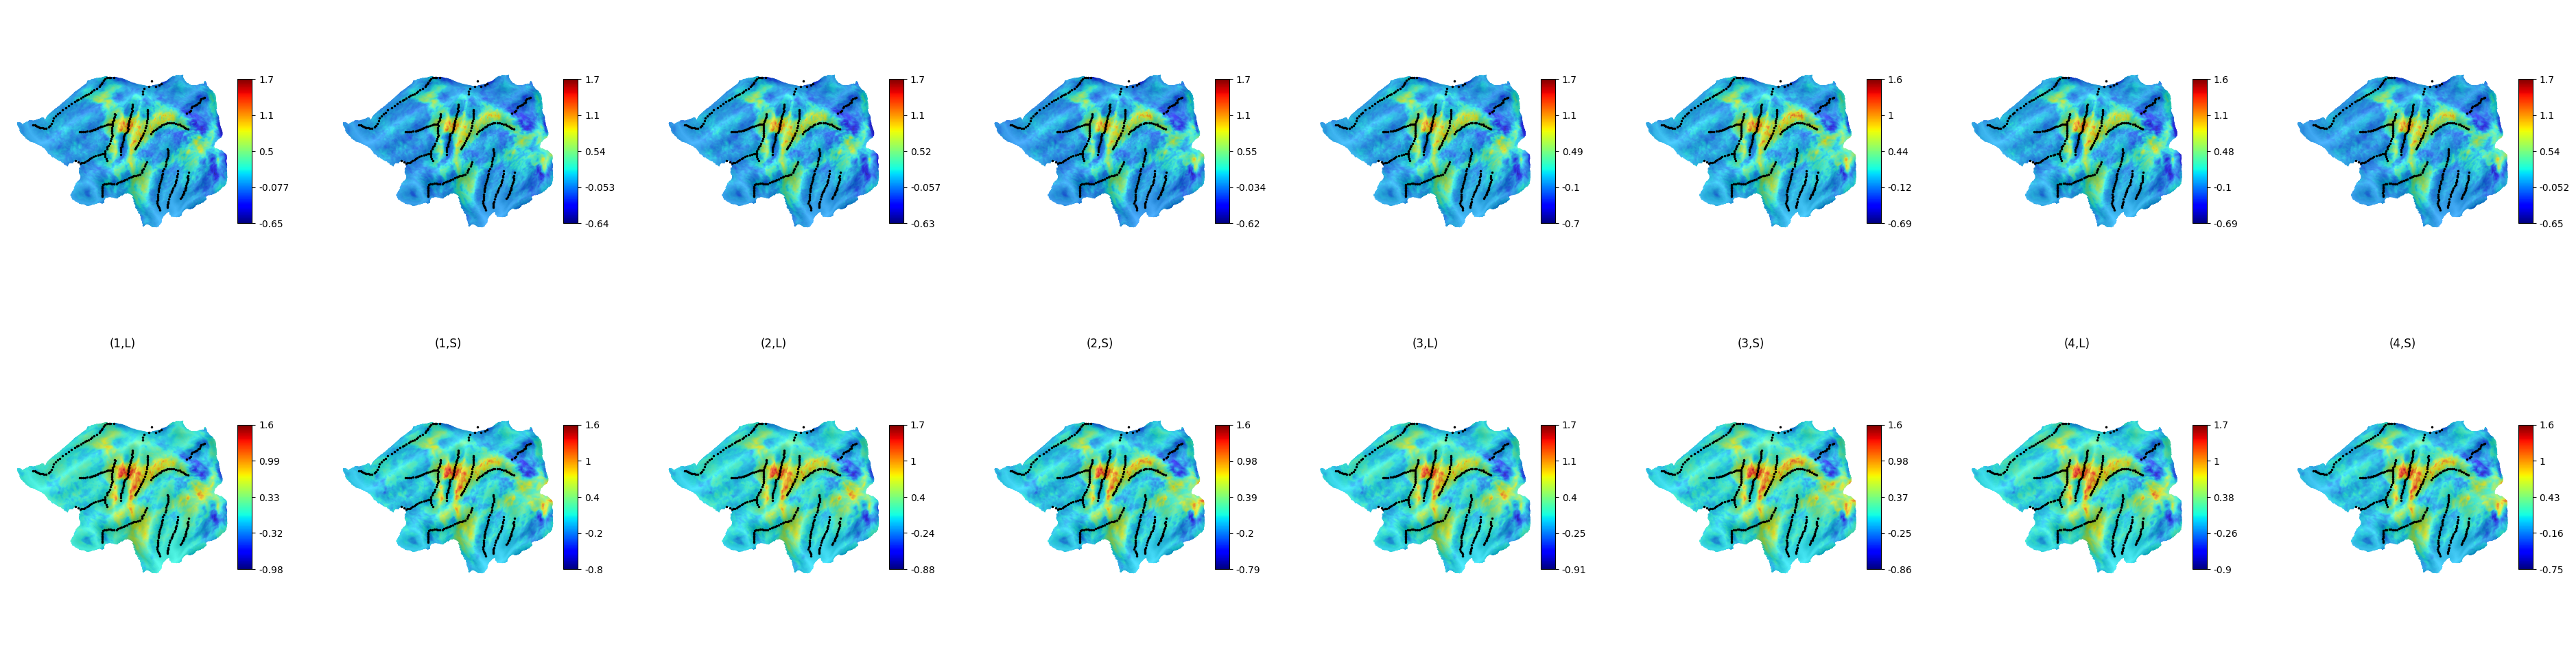

In [33]:
nrows, ncols = 2, 8
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))
# axs = np.concatenate(axs)

list_cond = reginfo.cond.unique()
for ii, sess in enumerate(['S','R']):
    group = np.arange(12)+12*ii
    for jj, cond in enumerate(list_cond):
        ## row: group (S/R), col: condition (seq,cue)
        ax = axs[ii,jj]
        plt.sca(ax)
        data = np.nanmean(Y[group][:,reginfo.cond==cond,:], axis=(0,1))
        g = surf.plot.plotmap(
            data=data,
            surf='fs32k_L',
            alpha=0.7, cmap=cm.jet, colorbar=True, 
            borders=border, bordercolor='black', bordersize=3,
            overlay_type='func', render='matplotlib'
        )
        if ii==1:
            ax.set_title(list_label[jj])
        if jj==0:
            ax.set_ylabel(sess)

In [29]:
dir_result = su.get_dir_result()
dir_work = join(dir_result,'GLM_%d.surf'%glm)
makedirs(dir_work, exist_ok=True)

In [30]:
fig.savefig(
    join(dir_work,'whole.glm_%d.beta_prewhiten.surf.png'%glm),
    dpi=300, facecolor=[1,1,1,1],
    bbox_inches='tight'
)

In [34]:
del fig
del Y

---

### Select the HRF parameter with the highest $R^{2}$ score.

In [16]:
# mins = []
# maxs = []
# for roi in list_roi:
#     G_hat = dict_G_hat[roi].mean(axis=0)
#     min_ = G_hat.min()
#     max_ = G_hat.max()
#     mins.append(min_)
#     maxs.append(max_)
# plt.plot(range(8),mins)
# plt.plot(range(8),maxs)

In [10]:
df_r2 = pd.read_csv(
    join(su.get_dir_result(),'mean_y_across_run/r2_score.tsv'),
    sep='\t', header=0
)
df_r2

,subj,sess,roi,param,r2
0,1,S,S1,"[4,14]",0.121725
1,1,R,S1,"[4,14]",0.246509
2,2,S,S1,"[4,14]",0.162380
3,2,R,S1,"[4,14]",0.374307
4,3,S,S1,"[4,14]",0.134179
...,...,...,...,...,...
1147,12,R,SPLp,"[9,19]",0.148224
1148,13,S,SPLp,"[9,19]",0.072790
1149,13,R,SPLp,"[9,19]",0.124870
1150,14,S,SPLp,"[9,19]",0.106808


In [11]:
df_tmp = df_r2.groupby(['subj','roi','param'], as_index=False).mean(['r2'])
df_param = df_tmp[df_tmp.r2==df_tmp.groupby(['subj','roi'])['r2'].transform('max')]
df_param.sort_values(by=['subj','roi'], ascending=[True,True])
# df_param['subj'] = df_param.subj.astype(str).str.zfill(2)
df_param

,subj,roi,param,r2
0,1,M1,"[4,14]",0.303799
7,1,PMd,"[5,15]",0.227037
13,1,PMv,"[5,15]",0.201462
19,1,S1,"[5,15]",0.252490
25,1,SMA,"[5,15]",0.139793
...,...,...,...,...
546,14,S1,"[4,14]",0.289173
552,14,SMA,"[4,14]",0.143694
559,14,SPLa,"[5,15]",0.208415
565,14,SPLp,"[5,15]",0.163065


---

## Encoding anaysis (second moment $G$)

In [12]:
glm = 1

In [13]:
reginfo = su.get_reginfo(subj='S01', glm=glm)
obs_des = {
    'cond_vec': reginfo.cond,
    'part_vec': reginfo.run
}
reginfo

,sn,run,cond,regIdx,seq,cue,reg
0,1,1,1,1,1,L,"(1,L)"
1,1,1,2,2,1,S,"(1,S)"
2,1,1,3,3,2,L,"(2,L)"
3,1,1,4,4,2,S,"(2,S)"
4,1,1,5,5,3,L,"(3,L)"
...,...,...,...,...,...,...,...
59,1,8,4,60,2,S,"(2,S)"
60,1,8,5,61,3,L,"(3,L)"
61,1,8,6,62,3,S,"(3,S)"
62,1,8,7,63,4,L,"(4,L)"


In [14]:
list_nn = su.get_list_sn()

list_subj = []
for ss in ['S','R']:
    for nn in list_nn:
        list_subj.append(ss+nn)
print(list_subj)

['S01', 'S02', 'S03', 'S05', 'S06', 'S08', 'S09', 'S10', 'S11', 'S12', 'S13', 'S14', 'R01', 'R02', 'R03', 'R05', 'R06', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13', 'R14']


In [15]:
list_roi = simage.get_list_roi()
list_roi

array(['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp'], dtype='<U4')

### Organizing data by ROI

In [16]:
dict_Y = {}
for roi in tqdm(list_roi):
    tmp = []
    for ss, subj in enumerate(list_subj):
        sidx = int(subj[1:])
        param = df_param[(df_param.subj==sidx)&(df_param.roi==roi)].param.values[0]
        beta_whiten = simage.get_prewhitened_beta(subj=subj,glm=glm,region=roi,param=param)
        dataset = pcm.dataset.Dataset(
            measurements=beta_whiten,
            obs_descriptors=obs_des
        )
        tmp.append(dataset)
    dict_Y[roi] = tmp
dict_Y.keys()

100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:14<00:00,  1.80s/it]


dict_keys([np.str_('S1'), np.str_('M1'), np.str_('PMd'), np.str_('PMv'), np.str_('SMA'), np.str_('V1'), np.str_('SPLa'), np.str_('SPLp')])

### - Second moment matrix $G$:
$$
G = \text{var}(U) = \frac{UU^{T}}{P}
$$

cf)
$$
Y = ZU + XB + \epsilon
$$
where $Y$ is activity data $(N \times P)$, $Z$ is a condition matrix $(N \times K)$, and $X$ is a fixed effect matrix to be removed. Additionally, $N$ represents the number of samples, $P$ stands for the number of voxels or channels, and $K$ denotes the number of conditions.

### - Remove fixed effects $X$ from $Y$
$$
Y' = Y - XB = Y - X\big(X^{+}Y\big)
$$
Now, the matrix $Y'$ can be organized as follows.
$$
Y' = ZU + \epsilon
$$
Here, if $Z$ represents an indicator for the condition, then $Y' = U$:
$$
Y'_{ij} = Z_{ik}U_{kj}, \text{ where } Z_{ik} = \delta_{ik}
$$

### - Cross-validation
Let $Z_{i}$ be the $Z$ matrix of the $i$-th block and $Y'_{i}$ be the $Y'$ matrix of the $i$-th block. If we denote all blocks except for the $i$-th block as $\neg i$, the matrix $U$ can be determined as follows.
$$U_{i}=Z_{i}^{+}Y'_{i} + \epsilon_{i}$$
$$U_{\neg i}=Z_{\neg i}^{+}Y'_{\neg i} + \epsilon_{\neg i}$$
Note that both $U_{i}$ and $U_{\neg i}$ are $(K \times P)$ matrices. The second moment matrix $\hat{G}$ can then be computed as follows:
$$
\hat{G} = \frac{1}{B}\sum_{i}^{B}\frac{U_{i}U_{\neg i}^{T}}{P}
$$
where $B$ denotes the number of blocks.

In [17]:
dict_G_hat = {}
for roi in tqdm(list_roi):
    Y = dict_Y[roi]
    G_hat = np.ones((len(list_subj),8,8)) * np.nan
    for ss, subj in enumerate(list_subj):
        G_hat[ss],_ = pcm.est_G_crossval(
            Y=Y[ss].measurements,
            Z=Y[ss].obs_descriptors['cond_vec'],
            part_vec=Y[ss].obs_descriptors['part_vec'],
            X=pcm.matrix.indicator(Y[ss].obs_descriptors['part_vec'])
        )
        if np.isnan(G_hat[ss]).sum()>0:
            print(' %s: %d'%(subj,np.isnan(Y[ss].measurements).sum()))
            tmp = Y[ss].measurements
    # print('%s: %d'%(roi,np.isnan(G_hat).sum()))
    dict_G_hat[roi] = G_hat

100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.05it/s]


In [33]:
# ## If Y is the beta map, then Y = U.
# roi = 'M1'
# idx = np.where(part_vec==1)[0]
# Y = dict_Y[roi][0][idx]
# print(Y.shape)
# Z = pcm.indicator(cond_vec[idx])
# print(Z.shape)
# U = np.linalg.pinv(Z)@Y
# print(U.shape)

# sns.heatmap(U-Y)

---

In [18]:
labels = reginfo.reg.unique()
labels

array(['(1,L)', '(1,S)', '(2,L)', '(2,S)', '(3,L)', '(3,S)', '(4,L)',
       '(4,S)'], dtype=object)

In [35]:
dir_result = su.get_dir_result()
dir_work = join(dir_result,'GLM_%d.PCM'%glm)

makedirs(dir_work, exist_ok=True)

In [36]:
nrows, ncols = 2, 12
# Estimate and plot the second moment matrices G across all data sets
for roi in tqdm(list_roi):    
    G_hat = dict_G_hat[roi]
    vmin = G_hat.mean(axis=0).min()
    vmax = G_hat.mean(axis=0).max()
    # vmin = None
    # vmax = None
    
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8*ncols, 6*nrows))
    axs = np.concatenate(axs)
    for ss, subj in enumerate(list_subj):
        sidx = int(subj[1:])
        param = df_param[(df_param.subj==sidx)&(df_param.roi==roi)].param.values[0]
        ax = axs[ss]
        plt.sca(ax)
        # ax.imshow(G_hat[subid,:,:],vmin=vmin,vmax=vmax)
        sns.heatmap(G_hat[ss,:,:], annot=True, fmt='.0e', ax=ax, vmin=vmin, vmax=vmax)
        ax.set_title('%s %s'%(subj,param), fontsize=18)
        ax.set_xticks(np.arange(len(labels)), labels, rotation=45, fontsize=14)
        ax.set_yticks(np.arange(len(labels)), labels, rotation=45, fontsize=14)
        plt.close()

        ## mean of each G_hat should be 0
    print(G_hat.mean(axis=(1,2)))
    fig.suptitle(roi, fontsize=20)
    fig.savefig(
        join(dir_work,'glm_%d.G_hat.%s.zrange_fixed.png'%(glm,roi)),
        dpi=300, facecolor=[1,1,1,1],
        bbox_inches='tight'
    )

  0%|                                                                                                    | 0/8 [00:00<?, ?it/s]

[-8.21621959e-20 -6.77626358e-21  1.94817578e-20  2.39710324e-19
 -1.86347248e-20 -8.47032947e-20  2.45639555e-19  3.21872520e-20
 -4.06575815e-20 -6.77626358e-20 -1.69406589e-21 -6.09863722e-20
 -4.40457133e-20 -1.03338020e-19 -7.19978005e-20  1.03338020e-19
  1.42301535e-19  9.82558219e-20  6.52215369e-19  9.12678001e-20
 -1.12496563e-22 -3.04931861e-20 -3.93023288e-19  5.08219768e-20]


 12%|███████████▌                                                                                | 1/8 [00:25<02:57, 25.38s/it]

[ 2.54109884e-21 -1.20702195e-19  6.09863722e-20  2.20228566e-20
 -1.32560656e-19 -5.59041745e-20 -3.38813179e-21 -2.54109884e-20
  0.00000000e+00 -6.94567017e-20  1.01643954e-19 -3.38813179e-20
  1.49077799e-19 -1.04185053e-19 -6.77626358e-20 -1.13502415e-19
 -1.10114283e-19 -6.09863722e-20 -1.99899776e-19 -6.13040096e-20
  1.56171700e-21 -2.99849663e-19 -1.60597447e-18 -4.06575815e-20]


 25%|███████████████████████                                                                     | 2/8 [00:51<02:36, 26.06s/it]

[ 9.48676901e-20  1.15196481e-19  1.43148568e-19 -6.77626358e-20
 -4.23516474e-20  2.10064171e-19  3.76082629e-19  3.11708125e-19
  1.01643954e-19 -8.47032947e-22  1.01643954e-20 -1.47807249e-19
 -1.62630326e-19 -7.45388994e-20  5.42101086e-20 -5.08219768e-20
 -8.49150530e-20 -1.10114283e-20  9.48676901e-20  4.91279109e-20
  6.35274710e-22 -6.09863722e-20 -3.79470760e-19 -8.47032947e-20]


 38%|██████████████████████████████████▌                                                         | 3/8 [01:18<02:10, 26.09s/it]

[ 2.71050543e-20  6.09863722e-20  3.98105485e-20 -6.26804381e-20
  9.91028548e-20  1.22819777e-19  2.49027686e-19  1.08420217e-19
 -9.65617560e-20  9.14795583e-20 -1.35525272e-19  9.48676901e-20
 -2.71050543e-19 -1.35525272e-20 -1.45689667e-19  2.28698896e-19
 -2.64274280e-19 -6.33157128e-20 -9.44441736e-20  3.32036915e-19
 -2.32934060e-21  1.59242194e-19 -1.33831206e-18 -7.87740641e-19]


 50%|██████████████████████████████████████████████                                              | 4/8 [01:43<01:43, 25.90s/it]

[-5.42101086e-20 -1.18584613e-20  1.10114283e-20 -4.40457133e-20
 -1.15196481e-19 -1.41030986e-19 -3.38813179e-21  0.00000000e+00
 -2.71050543e-20  7.83505476e-21 -8.72443936e-20  2.20228566e-20
 -2.43945489e-19  3.04931861e-20  1.50771865e-19 -6.77626358e-20
  1.34254722e-19  8.25857124e-21 -8.47032947e-20  2.91379334e-19
  9.13207396e-22 -5.75982404e-20 -2.03287907e-20 -2.20228566e-19]


 62%|█████████████████████████████████████████████████████████▌                                  | 5/8 [02:08<01:16, 25.35s/it]

[-9.21571847e-19 -7.58941521e-19 -2.27682456e-18 -3.52365706e-19
 -8.67361738e-19  4.33680869e-19 -2.43945489e-19  5.59041745e-20
 -1.51788304e-18  7.58941521e-19  2.05998413e-18  4.33680869e-19
 -3.79470760e-19  1.51788304e-18  1.51788304e-18 -4.20128342e-19
  4.33680869e-19 -9.48676901e-20  2.71050543e-20 -4.94667241e-19
 -5.92923063e-21 -4.77048956e-18 -9.21571847e-19  2.16840434e-18]


 75%|█████████████████████████████████████████████████████████████████████                       | 6/8 [02:32<00:50, 25.08s/it]

[ 1.28749008e-19  8.13151629e-20 -7.45388994e-20  7.79270311e-20
  1.98205710e-19 -2.54109884e-19  4.30292737e-19  3.72694497e-20
 -2.84603070e-19 -2.54109884e-20 -6.09863722e-20  9.14795583e-20
 -9.48676901e-20  1.76182853e-19  1.32137140e-19  9.82558219e-20
 -1.93123512e-19 -7.28448335e-20 -1.08420217e-19 -6.43745040e-19
 -5.29395592e-21  5.75982404e-20  2.71050543e-20 -4.81114714e-19]


 88%|████████████████████████████████████████████████████████████████████████████████▌           | 7/8 [02:57<00:24, 24.89s/it]

[-5.42101086e-19  5.01443505e-19 -2.84603070e-19  5.42101086e-19
 -1.89735380e-19  3.59141970e-19  7.31836466e-19 -5.35324823e-19
  2.43945489e-19 -1.62630326e-19  1.62630326e-19 -5.42101086e-20
 -8.67361738e-19 -5.42101086e-20  1.35525272e-19 -9.21571847e-19
 -3.25260652e-19  1.07996701e-19  1.89735380e-19 -2.50721752e-19
 -2.75285708e-21  8.13151629e-20  5.96311195e-19 -8.13151629e-19]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [03:21<00:00, 25.23s/it]


### Check the validation of $\hat{G}s$

1. summations

In [36]:
# ## row of G_hat
# print((G_hat.mean(axis=1) > 1e-8).sum())

# ## col of G_hat
# print((G_hat.mean(axis=2) > 1e-8).sum())

# ## diag of G_hat
# diagonals = np.array([np.diagonal(mat) for mat in G_hat])
# print(diagonals.shape, np.sum(diagonals, axis=1))
# sns.heatmap(diagonals, annot=True, fmt='.0e')

#### 2. correlation

i. correlation($\hat{G}_{i}, \hat{G}_{\neg i}$)

In [37]:
# for key, value in dataset_Y.items():
    # del dataset_Y[key][9+12-1]
    # del dataset_Y[key][9-1]

In [20]:
rows, cols = np.triu_indices(8)

list_ = []
for roi in tqdm(list_roi):
    ## obtain the second moment matrix G
    G_hat = dict_G_hat[roi]
    ## calculate correlation
    for ss, sess in enumerate(['S','R']):
        idx_s = [i+ss*12 for i in range(12)]
        G_sess = G_hat[idx_s]
        for nn, sid in enumerate(list_nn):
            idx_a = nn
            idx_b = [True if i!=nn else False for i in range(12)]
            a = G_sess[idx_a]
            b = np.mean(G_sess[idx_b], axis=0)
            a_upper = a[rows,cols]
            b_upper = b[rows,cols]
            coef, pval = pearsonr(a_upper, b_upper)
            list_.append(
                {'roi':roi, 'sess':sess, 'subj':sid, 'corr':coef, 'pval':pval}
            )
df = pd.DataFrame(list_)
df

100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 48.33it/s]


,roi,sess,subj,corr,pval
0,S1,S,01,0.586567,1.701050e-04
1,S1,S,02,0.201719,2.380892e-01
2,S1,S,03,0.157599,3.586296e-01
3,S1,S,05,0.065483,7.043596e-01
4,S1,S,06,-0.007708,9.644129e-01
...,...,...,...,...,...
187,SPLp,R,10,0.789202,1.070852e-08
188,SPLp,R,11,0.942849,8.510955e-18
189,SPLp,R,12,0.902604,5.357290e-14
190,SPLp,R,13,0.699877,2.029350e-06


Text(0.5, 1.0, 'glm_1')

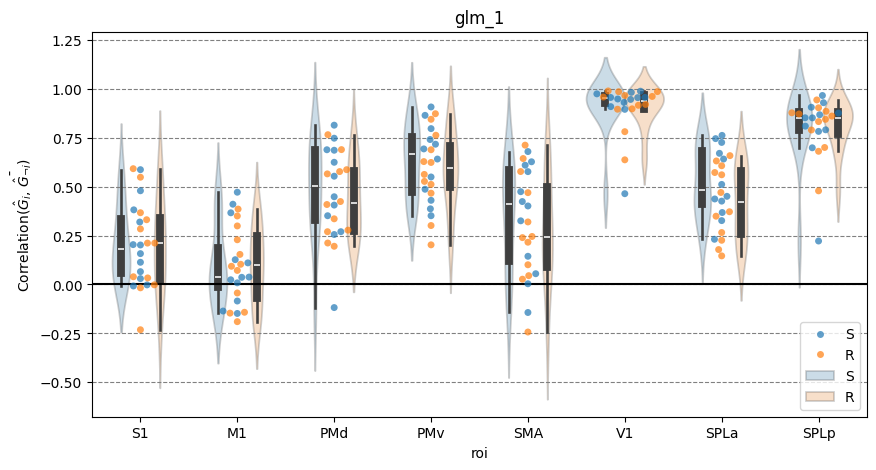

In [22]:
fig, ax = plt.subplots(figsize=(10,5))

sns.swarmplot(
    data=df,
    x='roi', y='corr', hue='sess',
    alpha=0.7,
    ax=ax
)
sns.violinplot(
    data=df,
    x='roi', y='corr', hue='sess',
    alpha=0.25,
    ax=ax
)
ax.grid(axis='y', linestyle='--', color='gray')
ax.legend()
ax.axhline(y=0, color='black')
# ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=40, ha='right')
ax.set_ylabel(r'Correlation($\hat{G}_{i}$, $\bar{\hat{G}_{\neg i}}$)')
ax.set_title('glm_%d'%glm)

S1 S 3.130e-03(**)
S1 R 1.725e-02(*)
PMd S 6.309e-05(****)
PMd R 6.551e-06(****)
PMv S 1.596e-07(****)
PMv R 7.200e-07(****)
SMA S 1.040e-03(**)
SMA R 5.646e-03(**)
V1 S 1.861e-10(****)
V1 R 5.672e-12(****)
SPLa S 6.463e-07(****)
SPLa R 8.520e-06(****)
SPLp S 2.052e-08(****)
SPLp R 2.329e-10(****)


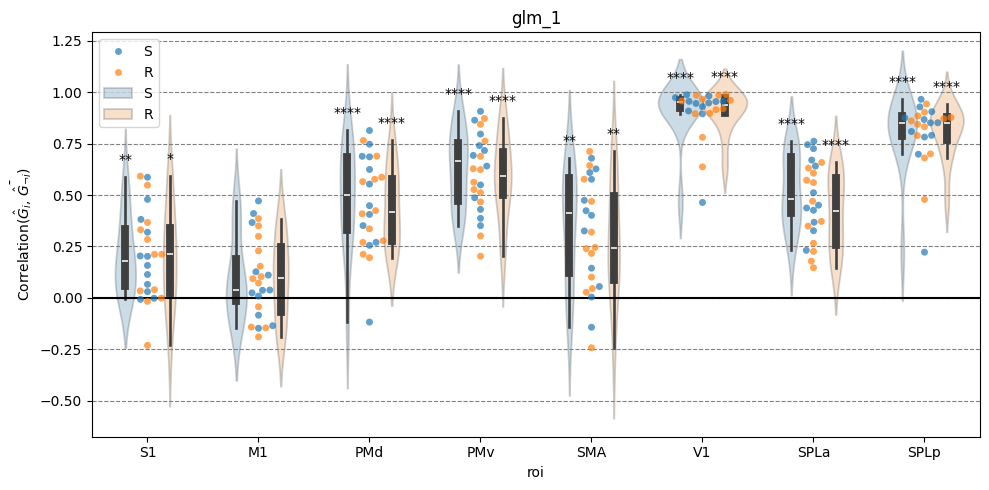

In [23]:
dy = np.diff(ax.get_ylim())*0.025

for ii, roi in enumerate(list_roi):
    for gg, group in enumerate(['S','R']):
        a = df[(df.roi==roi)&(df.sess==group)]['corr'].astype(float)
        tval, pval = ttest_1samp(a, popmean=0)
        if pval < 0.05:
            print(roi, group, '%.3e(%s)'%(pval,su.convert_pval_to_star(pval)))
            x = 0.4*(gg-0.5) + ii
            y = a.max() + dy
            ax.text(
                x=x, y=y,
                s=su.convert_pval_to_star(pval), fontsize=10,
                ha='center', va='bottom'
            )
fig.tight_layout()
fig

In [24]:
fig.savefig(
    join(dir_work,'glm_%d.G_hat.ROIs.correlation.png'%glm),
    dpi=300, facecolor=[1,1,1,1],
    bbox_inches='tight'
)

---

## PCM
### Build the models
Now we are building a list of models, using a list of second moment matrices

In [21]:
# Make an empty list
M = []

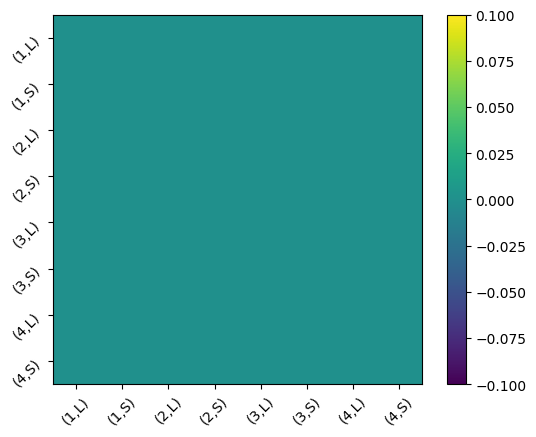

In [22]:
# Null model: All fingers are represented independently. 
# For RSA model that would mean that all distances are equivalent
model = np.eye(8)
model = np.zeros((8,8))

plt.imshow(model)
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels, rotation=45)
plt.colorbar()

M.append(pcm.FixedModel('null',model))

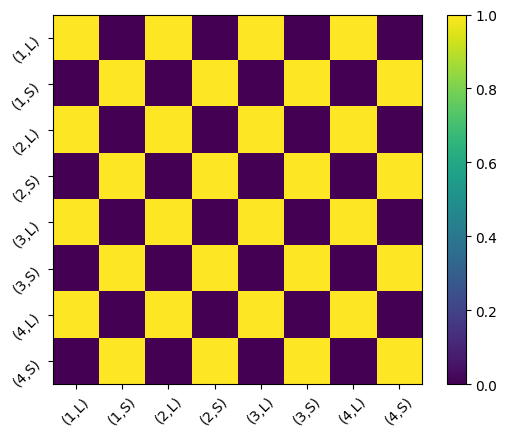

In [23]:
## Cue
model1 = np.zeros((8,8))
for row, a in enumerate(labels):
    for col, b in enumerate(labels):
        if ('L' in a)&('L' in b):
            val = 1
        elif ('S' in a)&('S' in b):
            val = 1
        else:
            val = 0
        model1[row,col] = val
plt.imshow(model1)
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels, rotation=45)
plt.colorbar()

M.append(pcm.FixedModel('Cue',model1))

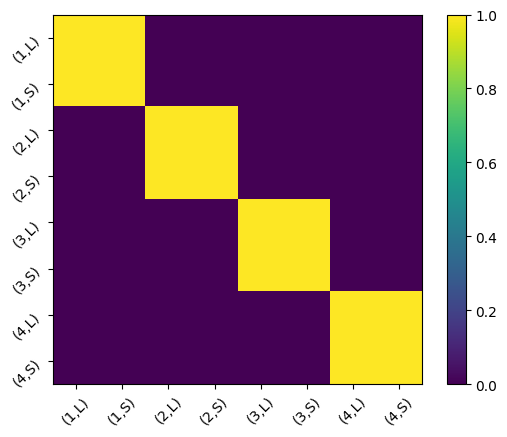

In [24]:
## Seq
model2 = np.zeros((8,8))
for row, a in enumerate(labels):
    for col, b in enumerate(labels):
        if ('1' in a)&('1' in b):
            val = 1
        elif ('2' in a)&('2' in b):
            val = 1
        elif ('3' in a)&('3' in b):
            val = 1
        elif ('4' in a)&('4' in b):
            val = 1
        else:
            val = 0
        model2[row,col] = val
plt.imshow(model2)
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels, rotation=45)
plt.colorbar()

M.append(pcm.FixedModel('Seq',model2))

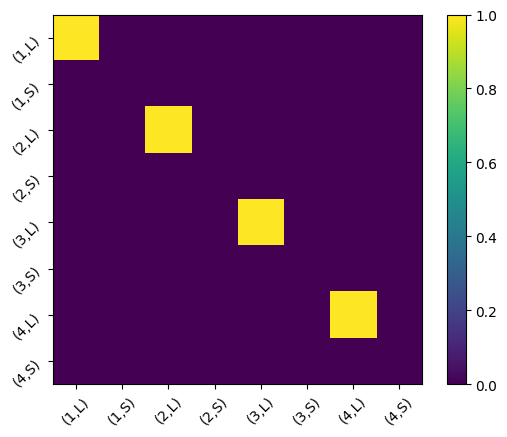

In [25]:
## Seq, Letter
model3 = np.zeros((8,8))
for row, a in enumerate(labels):
    for col, b in enumerate(labels):
        if ('S' in a)|('S' in b):
            val = 0
        else:
            if ('1' in a)&('1' in b):
                val = 1
            elif ('2' in a)&('2' in b):
                val = 1
            elif ('3' in a)&('3' in b):
                val = 1
            elif ('4' in a)&('4' in b):
                val = 1
            else:
                val = 0
        model3[row,col] = val
plt.imshow(model3)
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels, rotation=45)
plt.colorbar()

M.append(pcm.FixedModel('Seq_Letter',model3))

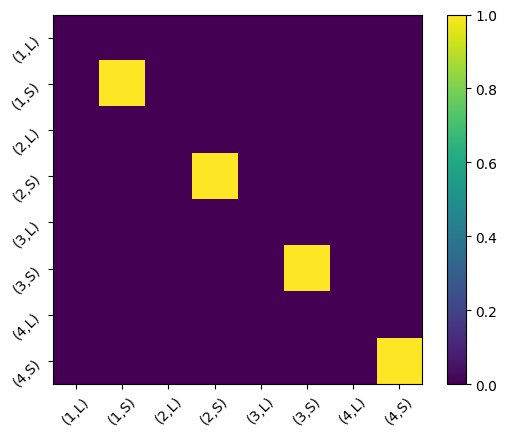

In [26]:
## Seq, Spatial
model4 = np.zeros((8,8))
for row, a in enumerate(labels):
    for col, b in enumerate(labels):
        if ('L' in a)|('L' in b):
            val = 0
        else:
            if ('1' in a)&('1' in b):
                val = 1
            elif ('2' in a)&('2' in b):
                val = 1
            elif ('3' in a)&('3' in b):
                val = 1
            elif ('4' in a)&('4' in b):
                val = 1
            else:
                val = 0
        model4[row,col] = val
plt.imshow(model4)
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels, rotation=45)
plt.colorbar()

M.append(pcm.FixedModel('Seq_Spatial',model4))

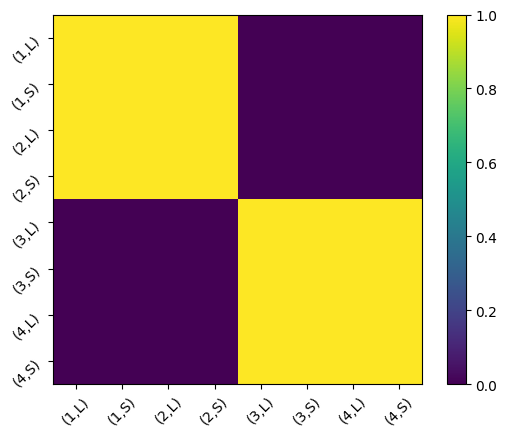

In [27]:
## first finger
model5 = np.zeros((8,8))
for row, a in enumerate(labels):
    for col, b in enumerate(labels):
        if ('1' in a)&('1' in b):
            val = 1
        elif ('1' in a)&('2' in b):
            val = 1
        elif ('2' in a)&('1' in b):
            val = 1
        elif ('2' in a)&('2' in b):
            val = 1
        elif ('1' in a)&('2' in b):
            val = 1
        elif ('3' in a)&('3' in b):
            val = 1
        elif ('3' in a)&('4' in b):
            val = 1
        elif ('4' in a)&('3' in b):
            val = 1
        elif ('4' in a)&('4' in b):
            val = 1
        else:
            val = 0
        model5[row,col] = val
plt.imshow(model5)
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels, rotation=45)
plt.colorbar()

M.append(pcm.FixedModel('first_finger',model5))

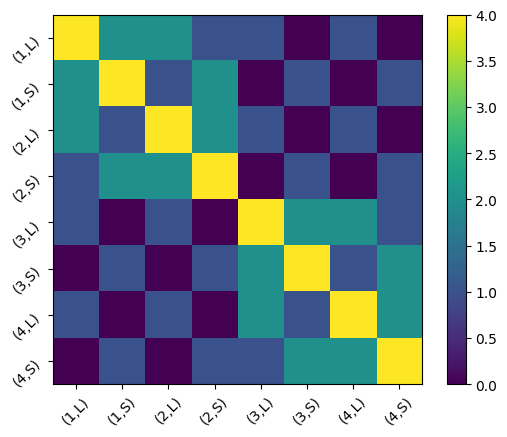

In [28]:
plt.imshow(model1+model2+model3+model4+model5)
plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels, rotation=45)
plt.colorbar()

M.append(pcm.ComponentModel('component',[model1,model2,model3,model4,model5]))

In [29]:
M.append(pcm.FreeModel('ceil',8)) # Noise ceiling model
M

### Model fitting

Now let's fit the models to individual data set. There are three ways to do this. We can fit the models
- to each individual participant with it's own parameters $\theta$.
- to each all participants together with shared parameters, but with an individual parameter for the signal strength and for group.
- in a cross-participant crossvalidated fashion. The models are fit to N-1 subjects and evaluated on the Nth subject.

100%|████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:39<00:00, 12.40s/it]


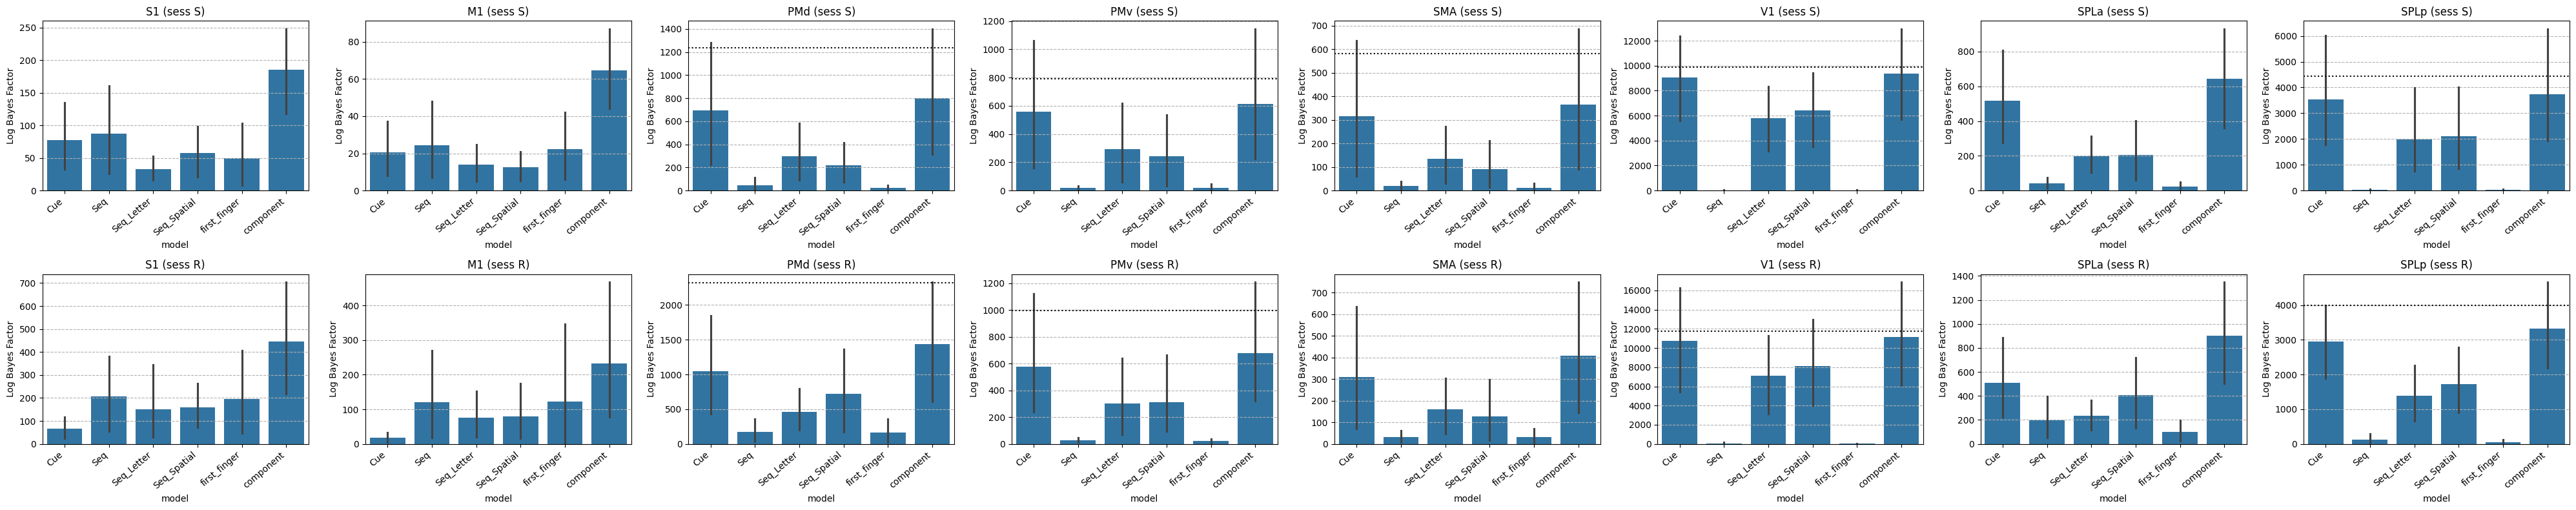

In [30]:
nrows = 2 ## group S/R
ncols = len(list_roi)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5,nrows*4))

for ii, (roi, Y) in enumerate(tqdm(dict_Y.items())):
    ## 1. session S
    ax = axs[0,ii]
    plt.sca(ax)
    
    # Do the individual fits - suppress verbose printout
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        T_in, theta_in = pcm.fit_model_individ(Y[:12], M, fit_scale = True, verbose = False)
    
    pcm.model_plot(
        T_in.likelihood,
        null_model = 'null', noise_ceiling= 'ceil'
    )
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=40, ha='right')
    ax.grid(axis='y', linestyle='--')
    ax.set_title('%s (sess S)'%roi)

    ## 2. session R
    ax = axs[1,ii]
    plt.sca(ax)
    
    # Do the individual fits - suppress verbose printout
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        T_in, theta_in = pcm.fit_model_individ(Y[12:], M, fit_scale = True, verbose = False)
    
    pcm.model_plot(
        T_in.likelihood,
        null_model = 'null', noise_ceiling= 'ceil'
    )
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=40, ha='right')
    ax.grid(axis='y', linestyle='--')
    ax.set_title('%s (sess R)'%roi)

fig.tight_layout()

In [48]:
T_in.columns

MultiIndex([('likelihood',         'null'),
            ('likelihood',          'Cue'),
            ('likelihood',          'Seq'),
            ('likelihood',   'Seq_Letter'),
            ('likelihood',  'Seq_Spatial'),
            ('likelihood', 'first_finger'),
            ('likelihood',    'component'),
            ('likelihood',         'ceil'),
            (     'noise',         'null'),
            (     'noise',          'Cue'),
            (     'noise',          'Seq'),
            (     'noise',   'Seq_Letter'),
            (     'noise',  'Seq_Spatial'),
            (     'noise', 'first_finger'),
            (     'noise',    'component'),
            (     'noise',         'ceil'),
            ('iterations',         'null'),
            ('iterations',          'Cue'),
            ('iterations',          'Seq'),
            ('iterations',   'Seq_Letter'),
            ('iterations',  'Seq_Spatial'),
            ('iterations', 'first_finger'),
            ('iterations',    'c

In [31]:
fig.savefig(
    join(dir_work,'glm_%d.pcm.T_in.png'%glm),
    dpi=300, facecolor=[1,1,1,1],
    bbox_inches='tight'
)

The likelihoods are very negative and quite different across participants, which is expected (see documentation). What we need to interpret are the difference is the likelihood relative to a null model. We can visualized these using the model_plot

In [32]:
def get_G_pred(M, theta_gr):
    res = []
    for model_num in [-2, -1]:
        model = M[model_num]
        G,_ = model.predict(theta_gr[model_num][:model.n_param])
        res.append(
            {'name': model.name, 'n_param':model.n_param, 'G_pred':G}
        )
    return res

  0%|                                                                                                    | 0/8 [00:00<?, ?it/s]

S1
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0
Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0
Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


 12%|███████████▍                                                                               | 1/8 [03:24<23:48, 204.11s/it]

M1
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0
Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0
Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


 25%|██████████████████████▊                                                                    | 2/8 [06:50<20:31, 205.29s/it]

PMd
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0
Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0
Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


 38%|██████████████████████████████████▏                                                        | 3/8 [10:13<17:01, 204.39s/it]

PMv
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0
Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0
Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


 50%|█████████████████████████████████████████████▌                                             | 4/8 [13:20<13:09, 197.48s/it]

SMA
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0
Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0
Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


 62%|████████████████████████████████████████████████████████▉                                  | 5/8 [16:33<09:47, 195.86s/it]

V1
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0
Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0
Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


 75%|████████████████████████████████████████████████████████████████████▎                      | 6/8 [19:36<06:23, 191.63s/it]

SPLa
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0
Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0
Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


 88%|███████████████████████████████████████████████████████████████████████████████▋           | 7/8 [22:48<03:11, 191.60s/it]

SPLp
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0
Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0
Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


100%|███████████████████████████████████████████████████████████████████████████████████████████| 8/8 [25:59<00:00, 194.94s/it]


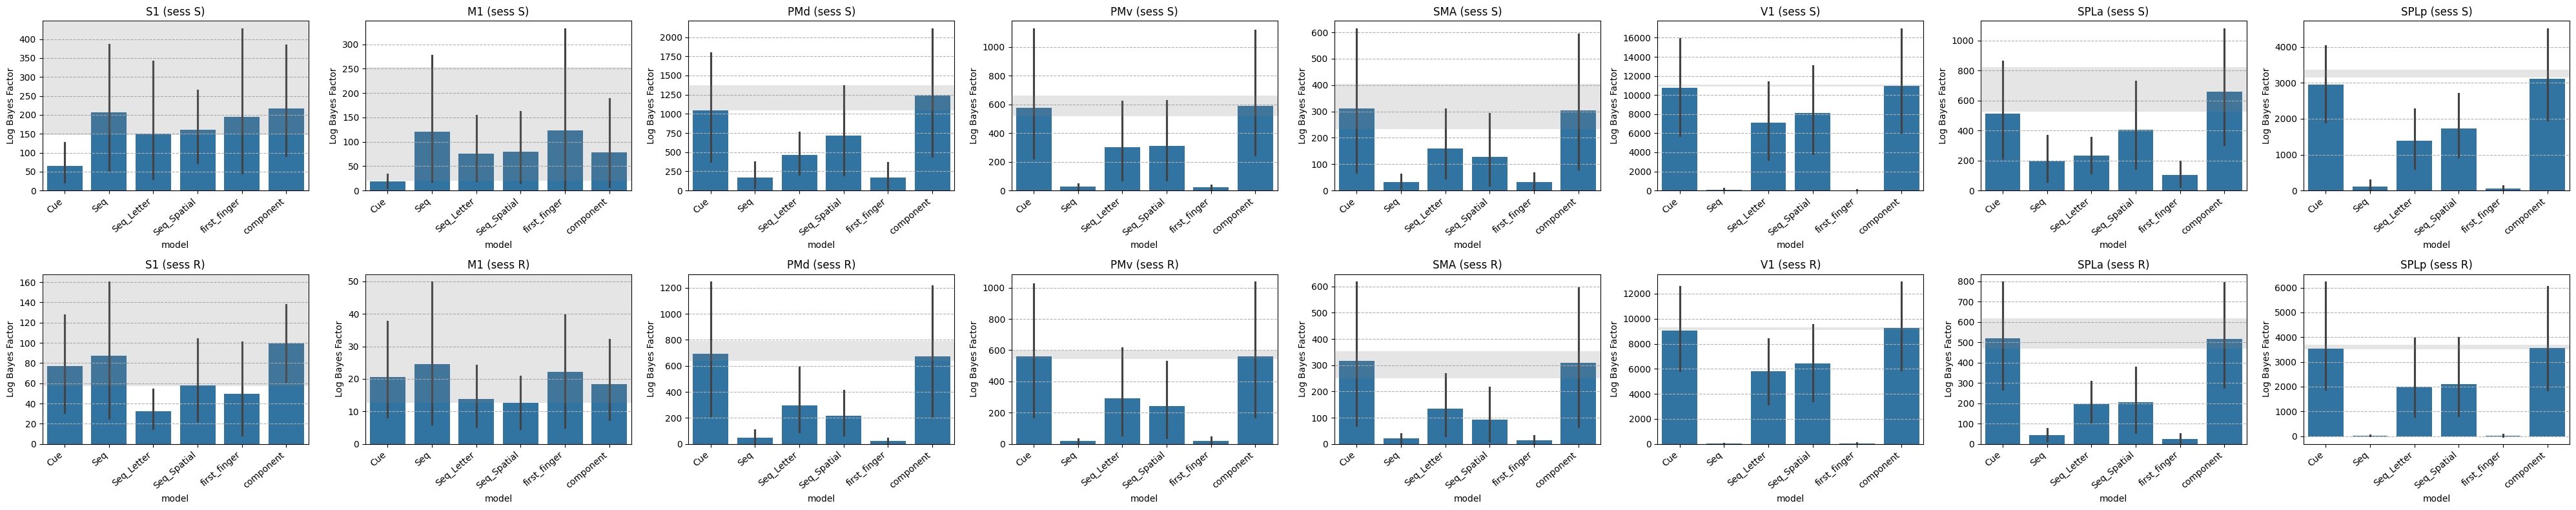

In [33]:
nrows = 2 ## group S/R
ncols = len(list_roi)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5,nrows*4))

model_pred = []
for ii, (roi, Y) in enumerate(tqdm(dict_Y.items())):
    print(roi)
    
    ## 1. group S
    ax = axs[0,ii]
    plt.sca(ax)
    
    # crossvalidated likelihood
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        T_gr, theta_gr = pcm.fit_model_group(Y[12:], M, fit_scale=True)
        T_cv, theta_cv = pcm.fit_model_group_crossval(Y[12:], M, fit_scale=True)

    tmp = {}
    tmp['sess']='S'
    tmp['roi']=roi
    res = get_G_pred(M, theta_gr)
    for dict_ in res:
        for key, val in dict_.items():
            tmp[key] = val
        model_pred.append(tmp.copy())
    
    pcm.model_plot(
        T_cv.likelihood,
        null_model = 'null', noise_ceiling= 'ceil',
        upper_ceiling = T_gr.likelihood['ceil']
    )
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=40, ha='right')
    ax.grid(axis='y', linestyle='--')
    ax.set_title('%s (sess S)'%roi)

    ## 2. group R
    ax = axs[1,ii]
    plt.sca(ax)
    
    # crossvalidated likelihood
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        T_gr, theta_gr = pcm.fit_model_group(Y[:12], M, fit_scale=True)
        T_cv, theta_cv = pcm.fit_model_group_crossval(Y[:12], M, fit_scale=True)

    tmp = {}
    tmp['sess']='R'
    tmp['roi']=roi
    res = get_G_pred(M, theta_gr)
    for dict_ in res:
        for key, val in dict_.items():
            tmp[key] = val
        model_pred.append(tmp.copy())
    
    pcm.model_plot(
        T_cv.likelihood,
        null_model = 'null', noise_ceiling= 'ceil',
        upper_ceiling = T_gr.likelihood['ceil']
    )
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=40, ha='right')
    ax.grid(axis='y', linestyle='--')
    ax.set_title('%s (sess R)'%roi)

fig.tight_layout()

In [53]:
T_gr.columns

MultiIndex([('likelihood',         'null'),
            ('likelihood',          'Cue'),
            ('likelihood',          'Seq'),
            ('likelihood',   'Seq_Letter'),
            ('likelihood',  'Seq_Spatial'),
            ('likelihood', 'first_finger'),
            ('likelihood',    'component'),
            ('likelihood',         'ceil'),
            (     'noise',         'null'),
            (     'noise',          'Cue'),
            (     'noise',          'Seq'),
            (     'noise',   'Seq_Letter'),
            (     'noise',  'Seq_Spatial'),
            (     'noise', 'first_finger'),
            (     'noise',    'component'),
            (     'noise',         'ceil'),
            (     'scale',         'null'),
            (     'scale',          'Cue'),
            (     'scale',          'Seq'),
            (     'scale',   'Seq_Letter'),
            (     'scale',  'Seq_Spatial'),
            (     'scale', 'first_finger'),
            (     'scale',    'c

In [54]:
T_cv.columns

MultiIndex([('likelihood',         'null'),
            ('likelihood',          'Cue'),
            ('likelihood',          'Seq'),
            ('likelihood',   'Seq_Letter'),
            ('likelihood',  'Seq_Spatial'),
            ('likelihood', 'first_finger'),
            ('likelihood',    'component'),
            ('likelihood',         'ceil'),
            (     'noise',         'null'),
            (     'noise',          'Cue'),
            (     'noise',          'Seq'),
            (     'noise',   'Seq_Letter'),
            (     'noise',  'Seq_Spatial'),
            (     'noise', 'first_finger'),
            (     'noise',    'component'),
            (     'noise',         'ceil'),
            (     'scale',         'null'),
            (     'scale',          'Cue'),
            (     'scale',          'Seq'),
            (     'scale',   'Seq_Letter'),
            (     'scale',  'Seq_Spatial'),
            (     'scale', 'first_finger'),
            (     'scale',    'c

In [34]:
fig.savefig(
    join(dir_work,'glm_%d.pcm.T_cv.png'%glm),
    dpi=300, facecolor=[1,1,1,1],
    bbox_inches='tight'
)

The problem with the noise ceiling is that it is individually fit to each subject. It has much more parameters than the models it is competing against, so it is overfitting. To compare models with different numbers of parameters directly, we need to look at our cross-validated group fits. The group fits can be used as an upper noise ceiling.

### Visualizing the model fit

Finally, it is very useful to visualize the model prediction in comparision to the fitted data. The model parameters are stored in the return argument `theta`. We can pass these to the `Model.predict()` function to get the predicted second moment matrix.

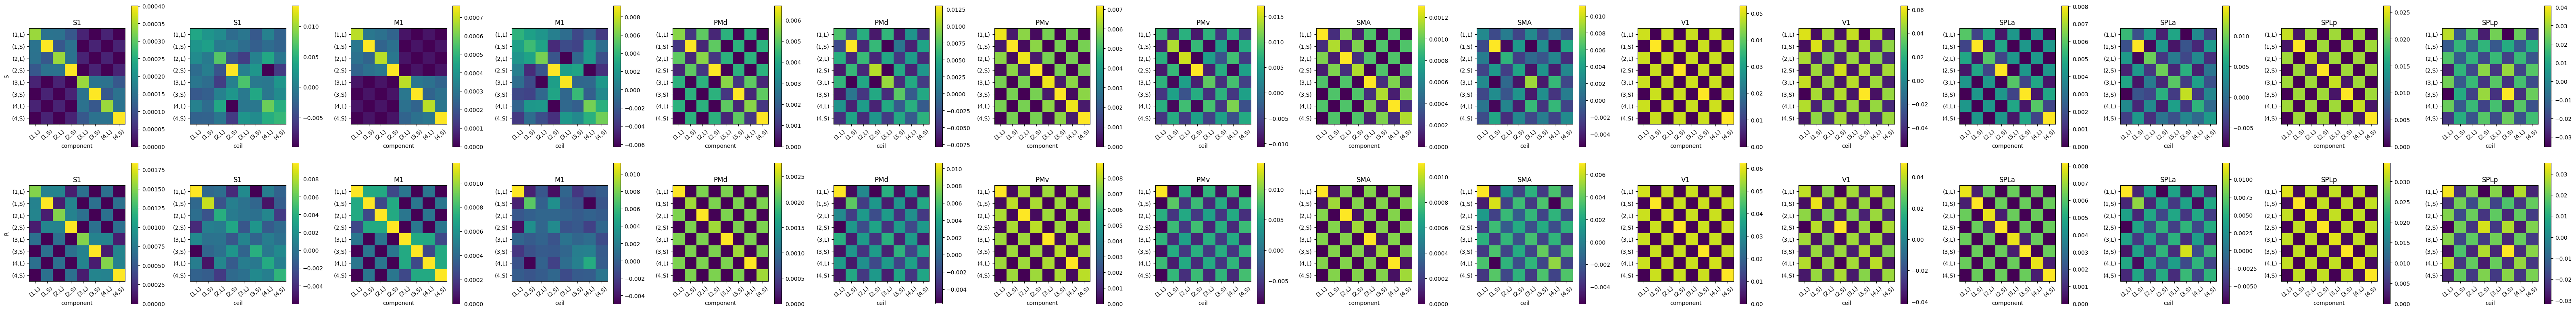

In [76]:
nrow = 2 # the number of sessions
ncols = len(model_pred)//2 # the number of ROIs * the number of models (=2)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4,nrows*4))

for ii, dict_ in enumerate(model_pred):
    ii_ = ii//2 # 0: (roi1,S), 1: (roi1,R), 2: (roi2,S), ...
    jj_ = ii%2 # model index 0: component, 1: ceil
        
    aa_ = ii_%2 # session index 0: S, 1: R
    bb_ = ii_//2 # roi index 0: roi1, 1: roi2, ...
    cc_ = bb_*2+jj_ # column index
    ax = axs[aa_, cc_]
    plt.sca(ax)

    G = dict_['G_pred']
    # for row in range(G.shape[0]):
    #     for col in range(G.shape[1]):
    #         text = plt.text(
    #             col, row, f"{G[row, col]:.1f}",
    #             ha="center", va="center", color="black"
    #         )
    plt.imshow(G)
    plt.colorbar()
    # plt.title('%s (%s)'%(dict_['roi'],dict_['name']))
    plt.title(dict_['roi'])
    plt.xlabel(dict_['name'])
    if cc_ == 0:
        plt.ylabel(dict_['sess'])
    else:
        plt.ylabel('')
    plt.xticks(ticks=range(8), labels=labels, rotation=40)
    plt.yticks(ticks=range(8), labels=labels, rotation=0)

fig.tight_layout()

---

## RDM

In [24]:
dir_surf = join('F:/SeqSpatialSupp_fMRI/surfaceWB')
dir_pattern = join(dir_work,'patterns/glm3.onset_move')
dir_atlas = join(dir_git,'diedrichsenlab/atlas/fs_LR_32k')
exists(dir_pattern)

True

In [25]:
underlay = join(dir_atlas,'fs_LR.32k.LR.sulc.dscalar.gii')
border = join(dir_git,'surfAnalysisPy/standard_mesh/fs_L/fs_LR.32k.L.border')

In [28]:
roi = nb.load(join(dir_atlas,'ROI.L.SSS.label.gii'))
list_roi = ['SMA', 'PMv', 'PMd', 'M1', 'S1', 'SPLa', 'SPLp', 'DSVC', 'MT+', 'VSVC', 'EAC']
data_roi = roi.darrays[0].data

### load residual

In [26]:
subj = 'S01'

In [29]:
ResMS = join(dir_work,'glm_3',subj,'ResMS.nii')

In [30]:
ResMS_mapped = surf.map.vol_to_surf(
    volumes=[ResMS],
    whiteSurfGifti=join(dir_surf,subj,'%s.L.white.32k.surf.gii'%subj),
    pialSurfGifti=join(dir_surf,subj,'%s.L.pial.32k.surf.gii'%subj),
    excludeThres=0.9,
    stats='nanmean'
)

<Axes: >

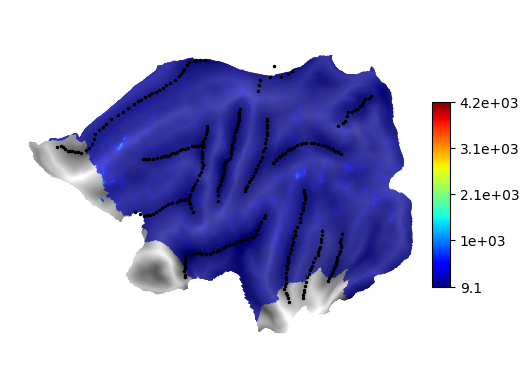

In [33]:
surf.plot.plotmap(
    data=ResMS_mapped,
    surf='fs32k_L',
    underlay=underlay, alpha=0.7, cmap=cm.jet, colorbar=True,
    borders=border, bordercolor='black', bordersize=3,
    overlay_type='func', render='matplotlib'
)

- ROIs:
    1. SMA
    2. PMv
    3. PMd
    4. M1
    5. S1
    6. SPLa
    7. SPLd
    8. DSVC
    9. MT+
    10. VSVC
    11. EAC
- State: $(s,c)$, where $s$ is Sequence, $c$ is Cue.
    1. $s$
        - 0: 32451
        - 1: 35124
        - 2: 13254
        - 3: 14523
    2. $c$ :
        - 0: letter
        - 1: spatial
- Transition: $(s_i, c_i) \rightarrow (s_f, c_f)$
    - 0: (0,0) -> (0,0)
    - 1: (0,0) -> (0,1)
    - $\vdots$
    - 63: (3,1) -> (3,1)

|     |(0,0)|(0,1)|(1,0)|(1,1)|(2,0)|(2,1)|(3,0)|(3,1)| 
|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|(0,0)|  B  | S00 | C01 | N02 | C03 | N04 | C05 | N06 |
|(0,1)|     |  B  | N07 | C08 | N09 | C10 | N11 | C12 |
|(1,0)|     |     |  B  | S13 | C14 | N15 | C16 | N17 |
|(1,1)|     |     |     |  B  | N18 | C19 | N20 | C21 |
|(2,0)|     |     |     |     |  B  | S22 | C23 | N24 |
|(2,1)|     |     |     |     |     |  B  | N25 | C26 |
|(3,0)|     |     |     |     |     |     |  B  | S27 |
|(3,1)|     |     |     |     |     |     |     |  B  |

$$\downarrow$$

|     |(0,0)|(1,0)|(2,0)|(3,0)|(0,1)|(1,1)|(2,1)|(3,1)| 
|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|(0,0)|  B  | C01 | C03 | C05 | S00 | N02 | N04 | N06 |
|(1,0)|     |  B  | C14 | C16 | N07 | S13 | N15 | N17 |
|(2,0)|     |     |  B  | C23 | N09 | N18 | S22 | N24 |
|(3,0)|     |     |     |  B  | N11 | N20 | N25 | S27 |
|(0,1)|     |     |     |     |  B  | C08 | C10 | C12 |
|(1,1)|     |     |     |     |     |  B  | C19 | C21 |
|(2,1)|     |     |     |     |     |     |  B  | C26 |
|(3,1)|     |     |     |     |     |     |     |  B  |

In [90]:
idx_RDM = np.array([
    1, 3, 5, 0, 2, 4, 6,
    14, 16, 7, 13, 15, 17,
    23, 9, 18, 22, 24,
    11, 20, 25, 27,
    8, 10, 12,
    19, 21,
    26
])

$$RDM = \begin{bmatrix}
\textcolor{gray}{B} & C & C & C & S & N & N & N \\
\cdot & \textcolor{gray}{B} & C & C & N & S & N & N \\
\cdot & \cdot & \textcolor{gray}{B} & C & N & N & S & N \\
\cdot & \cdot & \cdot & \textcolor{gray}{B} & N & N & N & S \\
\cdot & \cdot & \cdot & \cdot & \textcolor{gray}{B} & C & C & C \\
\cdot & \cdot & \cdot & \cdot & \cdot & \textcolor{gray}{B} & C & C \\
\cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \textcolor{gray}{B} & C \\
\cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \cdot & \textcolor{gray}{B}
\end{bmatrix}$$
The number of elements on the upper triangle $= \frac{8\cdot 7}{2} = 28$
- B: both of cue and sequence repetition (8 trials)
- S: only sequence repetition (8 trials)
- C: only cue repetition (24 trials)
- N: no repetition (24 trials)

In [91]:
RDM = np.array([
    'C', 'C', 'C', 'S', 'N', 'N', 'N',
         'C', 'C', 'N', 'S', 'N', 'N',
              'C', 'N', 'N', 'S', 'N',
                   'N', 'N', 'N', 'S',
                        'C', 'C', 'C',
                             'C', 'C',
                                  'C'
])

In [17]:
list_var = ['beta', 'glm', 'subj', 'nvoxels', 'ROI', 'normmode', 'RDM',]

subj = 'S01' ## -> ss
data = scipy.io.loadmat(join(dir_pattern,'%s_fRDM.glm3.mat'%subj))['Data']
for i, dd in enumerate(data[0,0]):
    print('i=%d: %s - %s'%(i,dd.shape,list_var[i]))
betas = data[0,0][0][:,0]
nvoxels = data[0,0][3][:,0]
rois = data[0,0][4][:,0]
rdms = data[0,0][6][:,0]

i=0: (11, 1) - beta
i=1: (22, 1) - glm
i=2: (22, 1) - subj
i=3: (22, 1) - nvoxels
i=4: (22, 1) - ROI
i=5: (11,) - normmode
i=6: (11, 1) - RDM


In [26]:
# list_diss = df.diss.unique()
list_diss = [
    'diffFing_within_L', 'diffFing_within_S', 'diffFing_across',
    'diffSeq_sameFing_within_L', 'diffSeq_sameFing_within_S', 'diffSeq_sameFing_across',
    'sameSeq_across'
]
list_diss

['diffFing_within_L',
 'diffFing_within_S',
 'diffFing_across',
 'diffSeq_sameFing_within_L',
 'diffSeq_sameFing_within_S',
 'diffSeq_sameFing_across',
 'sameSeq_across']

In [30]:
list_diss = []

for s, ss in enumerate(list_ss):
    for n, nn in enumerate(list_nn):
        subj = ss+nn
        fname = join(dir_pattern,'%s_fRDM.glm3.mat'%subj)
        if not exists(fname):
            ## R11, R13(?)이 문제. subj_fRDM.glm3.mat 파일을 만들지 못함
            continue
        data = scipy.io.loadmat(fname)['Data'][0,0]
        betas = data[0][:,0]
        nvoxels = data[3][:,0]
        rois = data[4][:,0]
        rdms = data[6][:,0]
        for rr, roi_ in enumerate(rois[:11]):
            roi = str(roi_[0])[4:-2]
            # print(roi)
            
            rdm = rdms[rr][0]
            rdm_ordered = rdm[idx_RDM].copy()
    
            list_diss.append({'sess':ss, 'subj':nn, 'roi':roi, 'diss':'sameSeq_across', 'mean':rdm_ordered[np.where(RDM=='S')[0]].mean()})
            list_diss.append({'sess':ss, 'subj':nn, 'roi':roi, 'diss':'diffSeq_across', 'mean':rdm_ordered[np.where(RDM=='N')[0]].mean()})
            
            tmp = np.where(RDM=='C')[0];
            list_diss.append({'sess':ss, 'subj':nn, 'roi':roi, 'diss':'diffSeq_within_L', 'mean':rdm_ordered[tmp[tmp<14]].mean()})
            list_diss.append({'sess':ss, 'subj':nn, 'roi':roi, 'diss':'diffSeq_within_S', 'mean':rdm_ordered[tmp[tmp>=14]].mean()})
            
            list_diss.append({'sess':ss, 'subj':nn, 'roi':roi, 'diss':'diffSeq_sameFing_within_L', 'mean':rdm_ordered[[0,13]].mean()})
            list_diss.append({'sess':ss, 'subj':nn, 'roi':roi, 'diss':'diffSeq_sameFing_within_S', 'mean':rdm_ordered[[22,27]].mean()})
            list_diss.append({'sess':ss, 'subj':nn, 'roi':roi, 'diss':'diffSeq_sameFing_across', 'mean':rdm_ordered[[4,9,17,20]].mean()})
            
            list_diss.append({'sess':ss, 'subj':nn, 'roi':roi, 'diss':'diffFing_within_L', 'mean':rdm_ordered[[1,2,7,8]].mean()})
            list_diss.append({'sess':ss, 'subj':nn, 'roi':roi, 'diss':'diffFing_within_S', 'mean':rdm_ordered[[23,24,25,26]].mean()})
            list_diss.append({'sess':ss, 'subj':nn, 'roi':roi, 'diss':'diffFing_across', 'mean':rdm_ordered[[5,6,11,12,14,15,18,19]].mean()})
            
            list_diss.append({'sess':ss, 'subj':nn, 'roi':roi, 'diss':'sameFing_across', 'mean':rdm_ordered[[3,4,9,10,16,17,20,21]].mean()})

In [31]:
df = pd.DataFrame(list_diss)
print(df.subj.unique())
df

['01' '02' '03' '05' '06' '08' '09' '10' '11' '12' '13' '14']


,sess,subj,roi,diss,mean
0,S,01,SMA,sameSeq_across,-6.991608e+12+8.886161e+ 11j
1,S,01,SMA,diffSeq_across,-4.847319e+12+1.283075e+ 12j
2,S,01,SMA,diffSeq_within_L,-2.150976e+12-6.085715e+ 11j
3,S,01,SMA,diffSeq_within_S,-3.644076e+12+2.145770e+ 12j
4,S,01,SMA,diffSeq_sameFing_within_L,1.368583e+12+2.195236e+ 12j
...,...,...,...,...,...
2415,R,10,EAC,diffSeq_sameFing_across,-1.826532e+12-3.294652e+ 12j
2416,R,10,EAC,diffFing_within_L,9.645179e+11-4.876234e+ 12j
2417,R,10,EAC,diffFing_within_S,2.106207e+12-5.686281e+ 12j
2418,R,10,EAC,diffFing_across,-1.033269e+11-5.070783e+ 12j


In [34]:
ncols = len(list_diss)
nrows = 1
# fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*ncols,6*nrows))
for ss, sess in enumerate(['S','R','total']):
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols,4*nrows))
    for ii, diss in enumerate(list_diss):
        # ax = axs[gg,ii]
        ax = axs[ii]
        plt.sca(ax)

        if not sess == 'total':
            df_tmp = df[(df.sess==sess)&(df.diss==diss)]
        else:
            df_tmp = df[df.diss==diss]
            
        sns.barplot(
            data=df_tmp,
            x='roi', y='mean',
            capsize=0.2, errorbar='se'
        )
        plt.xticks(rotation=30, fontsize=14)
        plt.ylabel('Mean Dissimilarity (A.U.)', fontsize=18)
        plt.xlabel('')
        plt.title('%s (sess %s)'%(diss,sess), fontsize=20)
        plt.grid(axis='y', linestyle='--')

    # fig.savefig(
    #     join(dir_work,'results/fig.barplot.glm3.rdm.%s.png'%group),
    #     dpi=300, facecolor=[1,1,1,1],
    #     bbox_inches = "tight"
    # )

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x000001B451A14AF0> (for post_execute), with arguments args (),kwargs {}:


ValueError: Image size of 1452000x400 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1452000x400 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1.452e+06x400 with 2420 Axes>

ValueError: Image size of 1452000x400 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1.452e+06x400 with 2420 Axes>

ValueError: Image size of 1452000x400 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1.452e+06x400 with 2420 Axes>

### Euclidean Distance $D^{2}$:

$$ diag(CGC^{T}) \rightarrow D^{2} $$

---